In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch import nn
from tqdm.auto import tqdm
import torchvision
import torch.optim as optim
from typing import Dict, List, Tuple
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks
!unzip pic_encoder



Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/gray/2932.jpg  
  inflating: landscape Images/g

In [3]:



color_folder = "/content/drive/MyDrive/Colab Notebooks/landscape Images/color"  # Replace with the path to your image folder
gray_folder ="/content/drive/MyDrive/Colab Notebooks/landscape Images/gray"

color_files=os.listdir(color_folder)
gray_files=os.listdir(gray_folder)
x=[]
y=[]
y_show=[]

image_files = [filename for filename in os.listdir(color_folder) if filename.endswith('.jpg')]
sorted_color_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))

image_files = [filename for filename in os.listdir(gray_folder) if filename.endswith('.jpg')]
sorted_gray_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))



transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))

])







for file_name in sorted_gray_files:
    file_path = os.path.join(gray_folder, file_name)

    image_pil = Image.open(file_path)
    transformed_image = transform(image_pil)
    image_np = np.array(transformed_image)
    x.append(image_np)


for file_name in sorted_color_files:
    file_path = os.path.join(color_folder, file_name)

    image_pil = Image.open(file_path)
    transformed_image = transform(image_pil)
    image_np = np.array(transformed_image)
    y.append(image_np)

for file_name in sorted_color_files:
    file_path = os.path.join(color_folder, file_name)

    image_pil = Image.open(file_path)
    image_pil = image_pil.resize((150, 150))
    image_np = np.array(image_pil)
    y_show.append(image_np)

x = np.array(x)
y = np.array(y)
y_show=np.array(y_show)



print(x.shape)
print(y.shape)
print(y_show.shape)


(7129, 1, 150, 150)
(7129, 3, 150, 150)
(7129, 150, 150, 3)


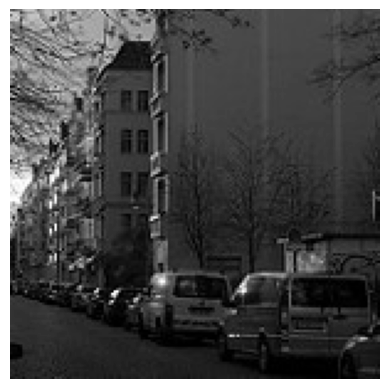

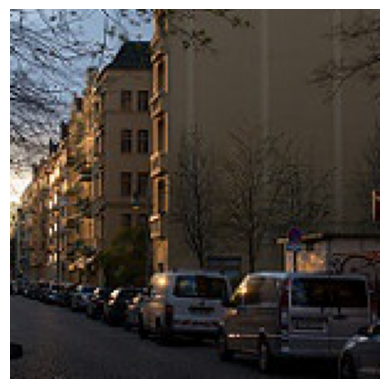

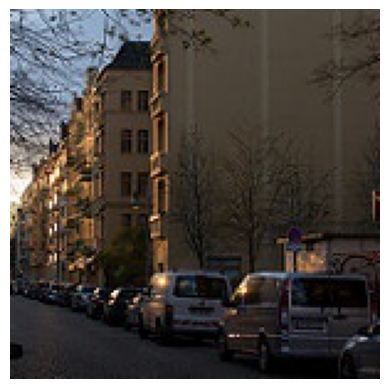

In [4]:
plt.imshow(x[0].squeeze(),cmap='gray')
plt.axis('off')
plt.show()


plt.imshow(y[0].transpose(1, 2, 0))
plt.axis('off')  # Remove axis ticks
plt.show()

plt.imshow(y_show[0])
plt.axis('off')  # Remove axis ticks
plt.show()

#print(x[0])
#print(y[0].shape)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, x, y ):
        self.x = x
        self.y = y


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        feature = self.x[idx]
        label = self.y[idx]
        feature=torch.tensor(feature,dtype=torch.float)
        labels=torch.tensor(label,dtype=torch.float)

        return feature, labels

In [26]:
def loader(x,y):

  dataset = CustomDataset(x,y)

  train_size = int(0.8 * len(dataset))
  test_size = len(dataset) - train_size

  print(train_size)
  print(test_size)
  train_dataset,teset_dataset =random_split(dataset,[train_size, test_size])

  train_dataloader = DataLoader(train_dataset ,batch_size=64, shuffle=True)
  test_dataloader=DataLoader(teset_dataset ,batch_size=64, shuffle=False)

  return train_dataloader ,test_dataloader

In [27]:

train_dataloader ,test_dataloader=loader(x,y)


5703
1426


In [ ]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), #32 150-3+2 = 149*149
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #64 [149-3+2*1]/2=74
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 128 [74-3+2*1]/1=73
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 256 [73-3=2*1]/2 =36
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [30]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 150, 150)  # Replace height and width with the actual values
            encoded_shape = self.encoder(dummy_input).shape[1:]
            self.num_features = encoded_shape.numel()

        # Latent space layers
        self.fc_mu = nn.Linear(self.num_features, self.latent_dim)
        self.fc_logvar = nn.Linear(self.num_features, self.latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.num_features),
            nn.ReLU(),
            nn.Unflatten(1, encoded_shape),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.num_features)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        decoded = self.decoder(z)
        return decoded

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [31]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()

    train_loss =[]
    for batch, (X, y) in enumerate(dataloader):
        X,y= X.to(device) , y.to(device)
        y_resized = F.interpolate(y, size=(152, 152), mode='bilinear', align_corners=False)

        y_pred = model(X)

        loss = loss_fn(y_pred, y_resized)
        train_loss.append(loss.item()* X.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_loss =sum(train_loss) / len(train_loss)

    return train_loss








def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):

    test_loss= []
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y= X.to(device) , y.to(device)
            y_resized = F.interpolate(y, size=(152, 152), mode='bilinear', align_corners=False)
            y_pred = model(X)

            loss = loss_fn(y_pred, y_resized)
            test_loss.append(loss.item()* X.size(0))



    test_loss =sum(test_loss) / len(test_loss)
    return test_loss









def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "test_loss": [],
               }
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss  = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
        f"Epoch: {epoch + 1} | "
        f"train_loss: {train_loss:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        )


        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results







def vae_loss(y, y_pred, mu, logvar):
    reconstruction_error = nn.functional.mse_loss(y_pred, y, reduction='sum')
   # reconstruction_error = nn.functional.binary_cross_entropy(y_pred, y, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    vae_loss = reconstruction_error + kl_divergence

    return vae_loss










def train_vae(
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device) :


  train_losses = []




  for epoch in range(epochs):
    for i, (x, y) in enumerate(train_dataloader):
      x = x.to(device)
      y = y.to(device)
      y= F.interpolate(y, size=(152, 152), mode='bilinear', align_corners=False)


      # Zero out the gradients
      optimizer.zero_grad()

      # Forward pass through the encoder and decoder networks
      y_pred, mu, logvar = vae(x)


      # Compute the VAE loss and backpropagate the gradients
      loss = vae_loss(y, y_pred, mu, logvar)
      loss.backward()
      optimizer.step()



      # Print the loss every 50 batches
     # if (i+1) % 50 == 0:
       # print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {loss.data.item():.4f}')


      if i % 100 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, epochs, i, len(train_dataloader), loss.item()))
              train_losses.append(loss.item())









  return train_losses









def plot_loss_curves_vae(results, title):



    epochs = range(len(results))

    plt.figure(figsize=(12, 4))
    plt.suptitle(title, fontsize=15)

     # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results, label="train_loss")
    plt.title("Loss")
    plt.xlabel("step")
    plt.legend()








def plot_loss_curves(results, title):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 4))
    plt.suptitle(title, fontsize=15)

     # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()



In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2509 | test_loss: 0.1802 | 
Epoch: 2 | train_loss: 0.1711 | test_loss: 0.1536 | 
Epoch: 3 | train_loss: 0.1589 | test_loss: 0.1520 | 
Epoch: 4 | train_loss: 0.1518 | test_loss: 0.1570 | 
Epoch: 5 | train_loss: 0.1493 | test_loss: 0.1388 | 
Epoch: 6 | train_loss: 0.1434 | test_loss: 0.1385 | 
Epoch: 7 | train_loss: 0.1423 | test_loss: 0.1416 | 
Epoch: 8 | train_loss: 0.1406 | test_loss: 0.1341 | 
Epoch: 9 | train_loss: 0.1382 | test_loss: 0.1345 | 
Epoch: 10 | train_loss: 0.1376 | test_loss: 0.1330 | 
Epoch: 11 | train_loss: 0.1368 | test_loss: 0.1321 | 
Epoch: 12 | train_loss: 0.1343 | test_loss: 0.1284 | 
Epoch: 13 | train_loss: 0.1341 | test_loss: 0.1384 | 
Epoch: 14 | train_loss: 0.1334 | test_loss: 0.1275 | 
Epoch: 15 | train_loss: 0.1325 | test_loss: 0.1266 | 
Epoch: 16 | train_loss: 0.1318 | test_loss: 0.1271 | 
Epoch: 17 | train_loss: 0.1304 | test_loss: 0.1272 | 
Epoch: 18 | train_loss: 0.1294 | test_loss: 0.1250 | 
Epoch: 19 | train_loss: 0.1279 | test

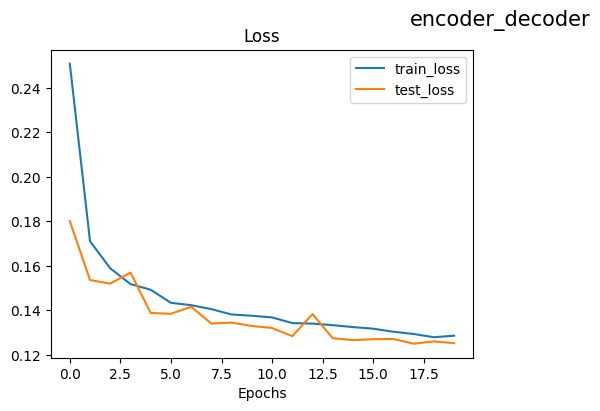

In [ ]:



model = ColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

results = train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
    epochs=20,
    device=device)

plot_loss_curves(results, title="encoder_decoder")

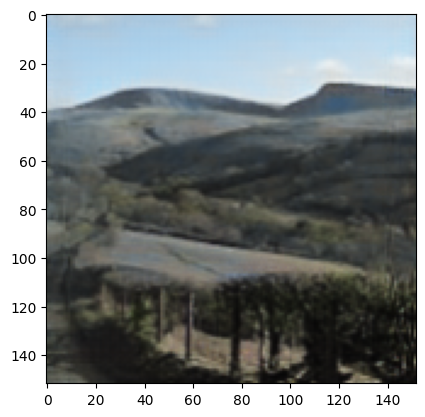

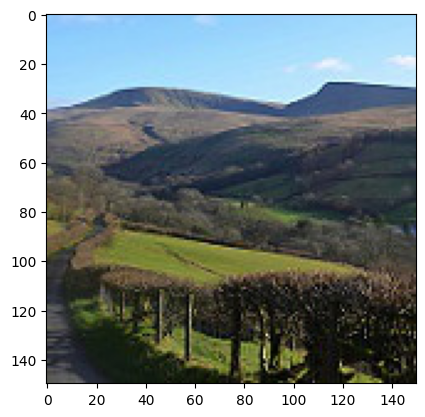

In [ ]:
for i, (features, labels) in enumerate(test_dataloader):
    if i == 53:
        x_test =features[0]
        y_test=labels[0]
        break




x_test=x_test.to(device)


with torch.no_grad():
    out=model(x_test).to(device)
    out=out.cpu().squeeze().detach().numpy()
    out=out.transpose(1, 2, 0)



plt.imshow(out)
plt.show()

y_test=y_test.numpy()
plt.imshow(y_test.transpose(1, 2, 0))
plt.show()





In [ ]:

latent_dim =100
learning_rate = 0.001
vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)


results=train_vae(
          train_dataloader,
          test_dataloader,
          optimizer=optimizer ,
          epochs=30,
          device=device)

plot_loss_curves_vae(results, title="VAE")

Epoch [1/30], Step [0/90], Loss: 372913.6875
Epoch [2/30], Step [0/90], Loss: 148281.5156
Epoch [3/30], Step [0/90], Loss: 129956.5625
Epoch [4/30], Step [0/90], Loss: 116712.0625
Epoch [5/30], Step [0/90], Loss: 109952.1094
Epoch [6/30], Step [0/90], Loss: 108216.0469


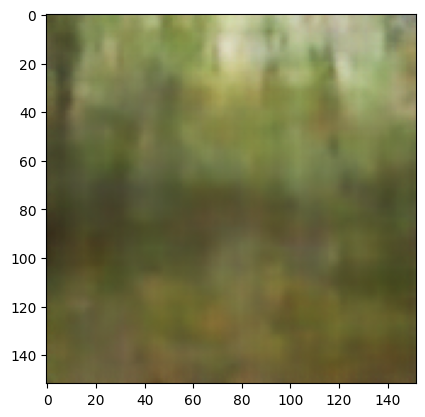

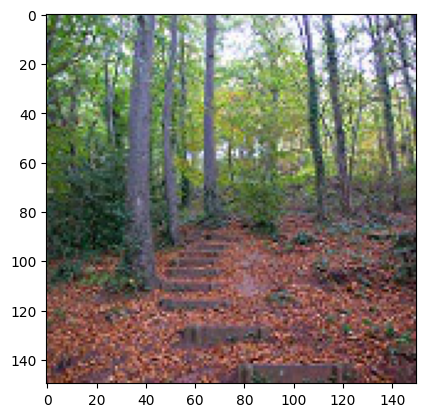

In [25]:

for i, (features, labels) in enumerate(test_dataloader):
    if i == 25:
        x_test =features[0]
        y_test=labels[0]
        break



x_test=x_test.to(device)


with torch.no_grad():
    out,mu, logvar = vae(x_test)
    out=out.cpu().squeeze().detach().numpy()
    out=out.transpose(1, 2, 0)



plt.imshow(out)
plt.show()

y_test=y_test.numpy()
plt.imshow(y_test.transpose(1, 2, 0))
plt.show()

torch.Size([3, 152, 152])


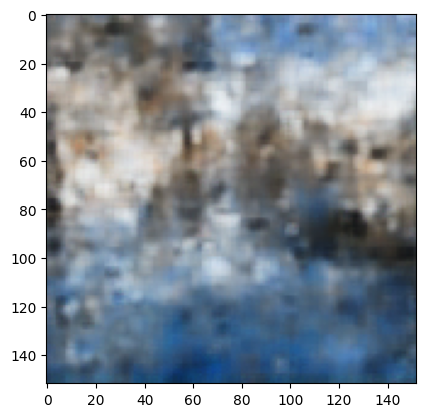

In [ ]:
vae.eval()

# Generate new samples
with torch.no_grad():
    # Sample random values from the latent space
    z = torch.randn(128, latent_dim).to(device)

    # Decode the latent space values into images
    generated_images = vae.decode(z)

# Print or visualize the generated images
print(generated_images[1].shape)

out=generated_images[1]
out=out.cpu().detach().numpy()
out=out.transpose(1, 2, 0)

plt.imshow(out)
plt.show()
